In [187]:
import requests
import datetime
import apimoex
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import scipy.optimize as sco
from scipy import stats

In [125]:
import seaborn as sns
sns.set_theme()

In [2]:
from_start_date = '2019-01-01'
to_end_date = '2021-01-01'

In [3]:
def get_data_moex(start_d=from_start_date, end_d=to_end_date):
    request_url = ('https://iss.moex.com/iss/engines/stock/markets/shares/boards/TQBR/securities.json')
    arguments = {'securities.columns': ('SECID,' 'REGNUMBER,' 'LOTSIZE,' 'SHORTNAME')}
    with requests.Session() as session:
        iss = apimoex.ISSClient(session, request_url, arguments)
        data = iss.get()
        df = pd.DataFrame(data['securities'])
    itg = []
    prc = []
    board = 'TQBR'
    for i in list(df['SECID']):
        try:
            data = apimoex.get_board_history(requests.Session(), i, start = start_d, end = end_d, board=board)
            data = pd.DataFrame(data)
            data = data[['TRADEDATE', 'CLOSE']]
            data = data.rename(columns={'CLOSE': i})
            data = data.set_index('TRADEDATE')
            itg.append(data)
        except:
            prc.append(i)
    
    g = []

    for i in range(len(itg)):
        if len(itg[i]) == 502:
            g.append(itg[i])

    ddd = g[0]
    for i in range(1,len(g)):
        ddd = ddd.merge(g[i], on='TRADEDATE')

    ddd = ddd.dropna(axis=1)
    return(ddd)

In [4]:
df = get_data_moex(start_d=from_start_date, end_d=to_end_date)

In [5]:
df.head()

,ABRD,AFKS,AFLT,AGRO,AKRN,ALRS,AMEZ,APTK,BANE,BANEP,...,TRNFP,TTLK,UNAC,UPRO,USBN,UTAR,VLHZ,VSMO,VTBR,YNDX
TRADEDATE,,,,,,,,,,,,,,,,,,,,,
2019-01-03,142.0,8.043,101.50,800.0,4692,99.99,3.960,5.075,1878.0,1779.0,...,168800,0.1784,0.796,2.620,0.0591,7.60,58.8,15580,0.034210,1859.5
2019-01-04,141.0,8.240,101.10,778.0,4688,101.55,3.954,5.140,1900.0,1789.0,...,173050,0.1786,0.800,2.600,0.0591,7.56,59.8,15600,0.034620,1916.0
2019-01-08,140.0,8.182,101.10,767.0,4680,98.65,3.980,5.105,1903.0,1772.0,...,169800,0.1772,0.796,2.560,0.0590,7.58,59.6,15620,0.034840,1926.5
2019-01-09,141.0,8.301,102.06,782.0,4664,101.40,4.050,5.380,1900.0,1797.0,...,167850,0.1800,0.800,2.601,0.0600,7.62,59.0,15700,0.035000,1960.0
2019-01-10,140.0,8.326,105.14,774.5,4650,102.95,4.046,5.750,1908.0,1894.0,...,169200,0.1842,0.801,2.602,0.0600,8.80,57.8,15900,0.035045,1985.0


In [26]:
def variables(df):
    returns = df.pct_change()
    mean_returns = returns.mean()
    cov_matrix = returns.cov()

    num_portfolios = 300000
    risk_free_rate = 0.025

    num_assets = len(df.columns)

    def rand_weights(n):
        k = np.random.rand(n)
        return k / sum(k)

    weight = rand_weights(len(list(df.columns)))
    
    return(returns, mean_returns, cov_matrix, num_portfolios, risk_free_rate, num_assets, weight)

returns, mean_returns, cov_matrix, num_portfolios, risk_free_rate, num_assets, weight = variables(df)

In [6]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [61]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate, txt_head=True):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    table = df
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    if txt_head==True:
        print("-"*80)
        print("Maximum Sharpe Ratio Portfolio Allocation\n")
        print("Annualised Return:", round(rp,2))
        print("Annualised Volatility:", round(sdp,2))
        print("\n")
        print(max_sharpe_allocation)
        print("-"*80)
        print("Minimum Volatility Portfolio Allocation\n")
        print("Annualised Return:", round(rp_min,2))
        print("Annualised Volatility:", round(sdp_min,2))
        print("\n")
        print(min_vol_allocation)
    
    plt.figure(figsize=(20, 9))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='o',color='r',s=100, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='o',color='g',s=100, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.27
Annualised Volatility: 0.14


            ABRD  AFKS  AFLT  AGRO  AKRN  ALRS  AMEZ  APTK  BANE  BANEP  ...  \
allocation  0.38  1.84  0.59  0.28   1.7  1.16  1.52  1.63  0.23   0.82  ...   

            TRNFP  TTLK  UNAC  UPRO  USBN  UTAR  VLHZ  VSMO  VTBR  YNDX  
allocation   1.61   1.1  0.22  1.72  0.75  0.36  0.58  0.01  0.74  1.85  

[1 rows x 115 columns]
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.2
Annualised Volatility: 0.13


            ABRD  AFKS  AFLT  AGRO  AKRN  ALRS  AMEZ  APTK  BANE  BANEP  ...  \
allocation  1.57  0.65  1.01  1.36  0.44   0.2  1.73   0.2  0.71   0.49  ...   

            TRNFP  TTLK  UNAC  UPRO  USBN  UTAR  VLHZ  VSMO  VTBR  YNDX  
allocation   0.97  1.01  0.24  1.17  1.44  0.89  1.12  0.24  1.87  0.64  

[1 r

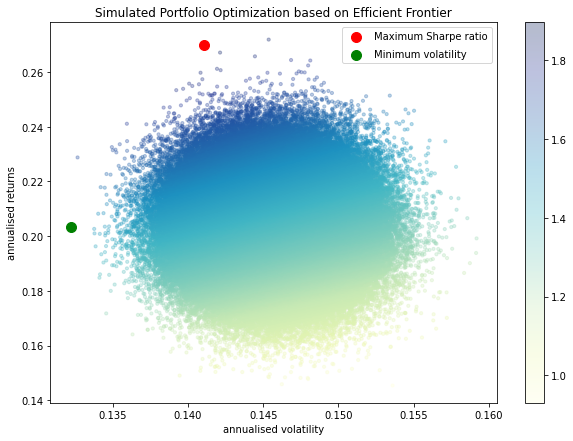

In [17]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

In [20]:
#получить только те активы, у которых положительная средняя доходность
def get_positive_returns(df):
    f = []
    for i in range(len(df.pct_change().mean())):
        if df.pct_change().mean()[i] < 0:
            f.append(df.pct_change().mean().index[i])  
    return(df.drop(f, axis=1))

In [27]:
df = get_positive_returns(df)
returns, mean_returns, cov_matrix, num_portfolios, risk_free_rate, num_assets, weight = variables(df)
df.head()

,ABRD,AFKS,AGRO,AKRN,ALRS,AMEZ,APTK,BELU,BLNG,BRZL,...,TGKD,TGKDP,TRMK,TTLK,UPRO,USBN,VLHZ,VSMO,VTBR,YNDX
TRADEDATE,,,,,,,,,,,,,,,,,,,,,
2019-01-03,142.0,8.043,800.0,4692,99.99,3.960,5.075,410,2.750,888,...,0.002822,0.003290,54.6,0.1784,2.620,0.0591,58.8,15580,0.034210,1859.5
2019-01-04,141.0,8.240,778.0,4688,101.55,3.954,5.140,404,2.735,890,...,0.002870,0.003310,55.0,0.1786,2.600,0.0591,59.8,15600,0.034620,1916.0
2019-01-08,140.0,8.182,767.0,4680,98.65,3.980,5.105,410,2.730,878,...,0.002878,0.003325,54.2,0.1772,2.560,0.0590,59.6,15620,0.034840,1926.5
2019-01-09,141.0,8.301,782.0,4664,101.40,4.050,5.380,408,2.740,874,...,0.002922,0.003370,54.4,0.1800,2.601,0.0600,59.0,15700,0.035000,1960.0
2019-01-10,140.0,8.326,774.5,4650,102.95,4.046,5.750,410,2.755,874,...,0.002900,0.003345,54.7,0.1842,2.602,0.0600,57.8,15900,0.035045,1985.0


In [23]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

In [59]:
def display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate, annot=False):
    
    def efficient_return(mean_returns, cov_matrix, target):
        num_assets = len(mean_returns)
        args = (mean_returns, cov_matrix)
        
        def portfolio_return(weights):
            return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

        constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                       {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        bounds = tuple((0,1) for asset in range(num_assets))
        result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
        return result


    def efficient_frontier(mean_returns, cov_matrix, returns_range):
        efficients = []
        for ret in returns_range:
            efficients.append(efficient_return(mean_returns, cov_matrix, ret))
        return efficients
    
    table = df

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    an_vol = np.std(returns) * np.sqrt(252)
    an_rt = mean_returns * 252
    
    print( "Minimum Volatility Portfolio Allocation\n")
    print( "Annualised Return:", round(rp_min,2))
    print( "Annualised Volatility:", round(sdp_min,2))
    print( "\n")
    print( min_vol_allocation)

    
    fig, ax = plt.subplots(figsize=(20, 9))
    ax.scatter(an_vol,an_rt,marker='o',s=200)
    
    if annot==True:
        for i, txt in enumerate(table.columns):
            ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
    ax.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.34, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    ax.set_title('Portfolio Optimization with Individual Stocks')
    ax.set_xlabel('annualised volatility')
    ax.set_ylabel('annualised returns')
    ax.legend(labelspacing=0.8)
    return(min_vol_allocation)

Minimum Volatility Portfolio Allocation

Annualised Return: 0.2
Annualised Volatility: 0.08


            ABRD  AFKS  AGRO   AKRN  ALRS  AMEZ  APTK  BELU  BLNG  BRZL  ...  \
allocation  2.29   0.0   0.0  32.38   0.0   0.0  1.88  6.23   0.0  2.16  ...   

            TGKD  TGKDP  TRMK  TTLK  UPRO  USBN  VLHZ  VSMO  VTBR  YNDX  
allocation   0.0    0.0   0.0   0.0  3.91  0.72   0.0   0.0   0.0   0.0  

[1 rows x 92 columns]


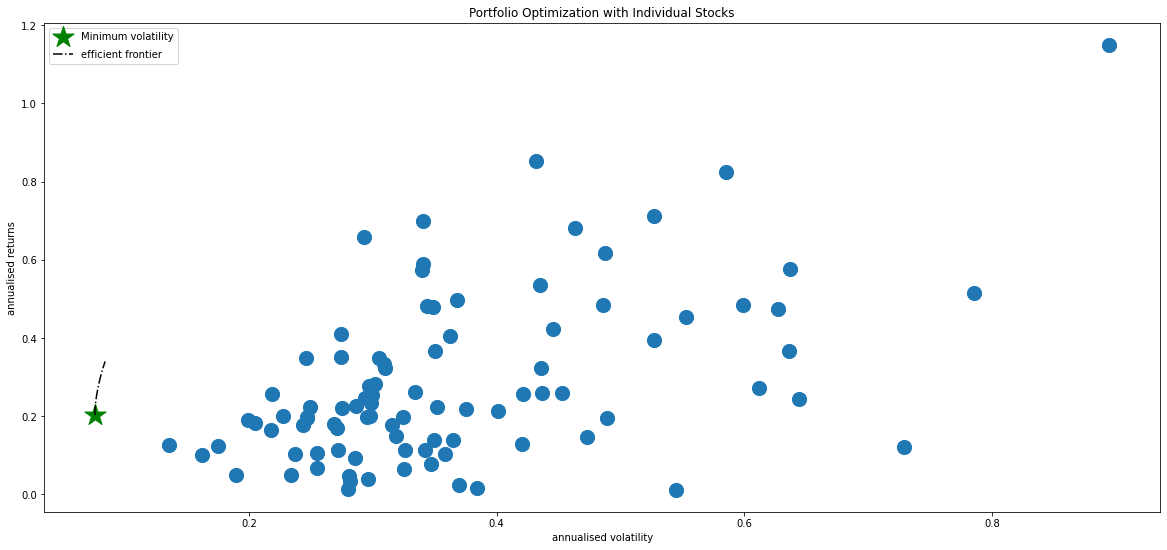

In [39]:
w = display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate)

In [51]:
def get_relevant_stocks(w):
    w = w.T['allocation']
    stocks = []
    weight = []

    for i in range(len(list(dict(w).keys()))):
        if list(dict(w).values())[i] > 0:
            stocks.append(list(dict(w).keys())[i])
            weight.append(list(dict(w).values())[i])
            
    res = {}
    for key in stocks:
        for value in weight:
            res[key] = value
            weight.remove(value)
            break
    return(res)


weights_dict = get_relevant_stocks(w)

In [58]:
df = df[list(weights_dict.keys())]
returns, mean_returns, cov_matrix, num_portfolios, risk_free_rate, num_assets, weight = variables(df)
df.head()

,ABRD,AKRN,APTK,BELU,BRZL,BSPB,CBOM,CHMK,CNTLP,DIOD,...,PIKK,PLZL,PMSBP,RTKM,RTKMP,SELG,SNGSP,STSBP,UPRO,USBN
TRADEDATE,,,,,,,,,,,,,,,,,,,,,
2019-01-03,142.0,4692,5.075,410,888,44.60,5.170,2530,12.30,4.090,...,374.7,5299.5,72.5,72.96,61.0,9.99,39.15,0.249,2.620,0.0591
2019-01-04,141.0,4688,5.140,404,890,45.50,5.173,2525,12.40,4.095,...,375.2,5286.5,72.8,73.15,61.0,10.00,38.80,0.250,2.600,0.0591
2019-01-08,140.0,4680,5.105,410,878,44.96,5.174,2530,12.52,4.155,...,376.6,5134.5,73.0,73.50,61.6,10.05,38.66,0.248,2.560,0.0590
2019-01-09,141.0,4664,5.380,408,874,45.00,5.152,2500,12.34,4.240,...,374.7,5275.0,73.4,73.76,61.8,10.01,38.39,0.256,2.601,0.0600
2019-01-10,140.0,4650,5.750,410,874,45.30,5.163,2530,12.28,4.260,...,374.2,5414.0,73.8,71.38,61.0,9.90,39.00,0.258,2.602,0.0600


Minimum Volatility Portfolio Allocation

Annualised Return: 0.2
Annualised Volatility: 0.08


            ABRD   AKRN  APTK  BELU  BRZL  BSPB  CBOM  CHMK  CNTLP  DIOD  ...  \
allocation  2.26  32.38  1.87  6.23  2.16  3.08  9.02  1.16    0.9  1.04  ...   

            PIKK  PLZL  PMSBP  RTKM  RTKMP  SELG  SNGSP  STSBP  UPRO  USBN  
allocation  1.86  0.76   0.06  3.66    1.4  0.26   3.67    0.8  3.88  0.73  

[1 rows x 30 columns]


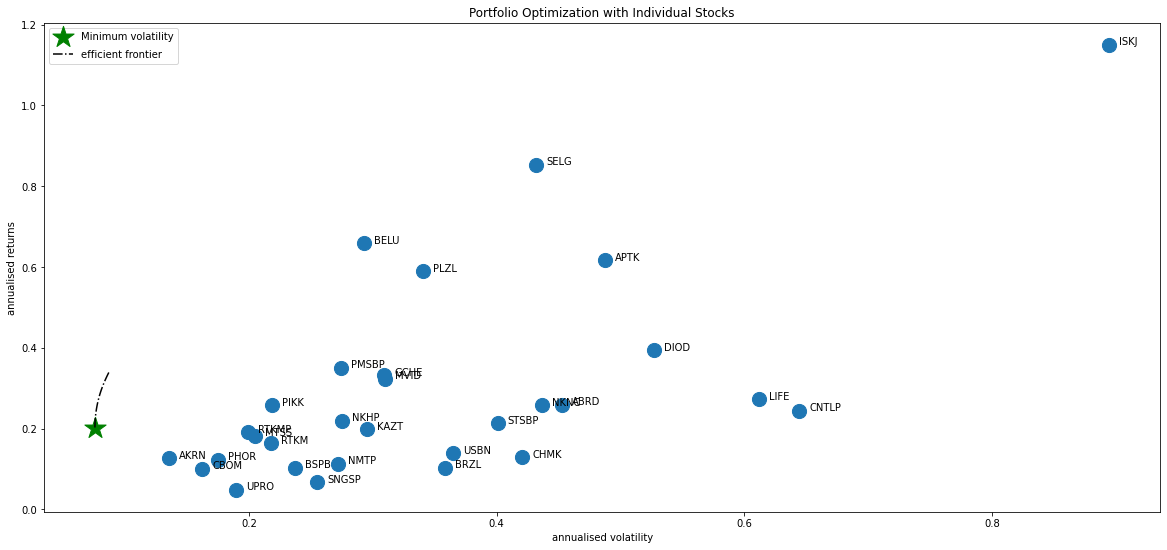

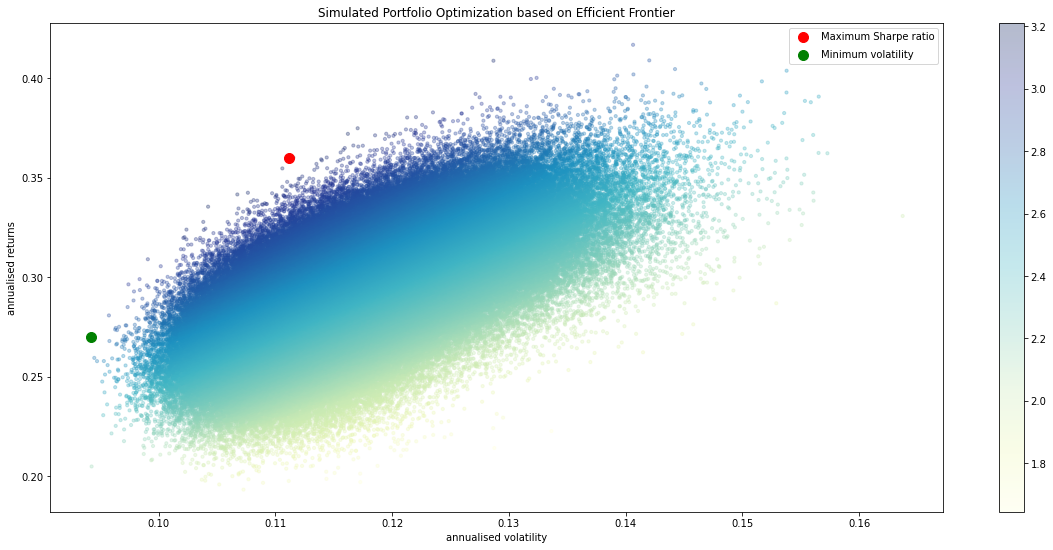

In [62]:
display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate, True)
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate, txt_head=False)

In [63]:
df.head()

,ABRD,AKRN,APTK,BELU,BRZL,BSPB,CBOM,CHMK,CNTLP,DIOD,...,PIKK,PLZL,PMSBP,RTKM,RTKMP,SELG,SNGSP,STSBP,UPRO,USBN
TRADEDATE,,,,,,,,,,,,,,,,,,,,,
2019-01-03,142.0,4692,5.075,410,888,44.60,5.170,2530,12.30,4.090,...,374.7,5299.5,72.5,72.96,61.0,9.99,39.15,0.249,2.620,0.0591
2019-01-04,141.0,4688,5.140,404,890,45.50,5.173,2525,12.40,4.095,...,375.2,5286.5,72.8,73.15,61.0,10.00,38.80,0.250,2.600,0.0591
2019-01-08,140.0,4680,5.105,410,878,44.96,5.174,2530,12.52,4.155,...,376.6,5134.5,73.0,73.50,61.6,10.05,38.66,0.248,2.560,0.0590
2019-01-09,141.0,4664,5.380,408,874,45.00,5.152,2500,12.34,4.240,...,374.7,5275.0,73.4,73.76,61.8,10.01,38.39,0.256,2.601,0.0600
2019-01-10,140.0,4650,5.750,410,874,45.30,5.163,2530,12.28,4.260,...,374.2,5414.0,73.8,71.38,61.0,9.90,39.00,0.258,2.602,0.0600


In [64]:
weights_dict

{'ABRD': 2.29,
 'AKRN': 32.38,
 'APTK': 1.88,
 'BELU': 6.23,
 'BRZL': 2.16,
 'BSPB': 3.08,
 'CBOM': 8.96,
 'CHMK': 1.18,
 'CNTLP': 0.91,
 'DIOD': 1.01,
 'GCHE': 1.44,
 'ISKJ': 0.53,
 'KAZT': 3.48,
 'LIFE': 0.47,
 'MTSS': 0.34,
 'MVID': 5.26,
 'NKHP': 1.96,
 'NKNC': 0.74,
 'NMTP': 0.04,
 'PHOR': 8.64,
 'PIKK': 1.86,
 'PLZL': 0.75,
 'PMSBP': 0.06,
 'RTKM': 3.67,
 'RTKMP': 1.35,
 'SELG': 0.25,
 'SNGSP': 3.63,
 'STSBP': 0.81,
 'UPRO': 3.91,
 'USBN': 0.72}

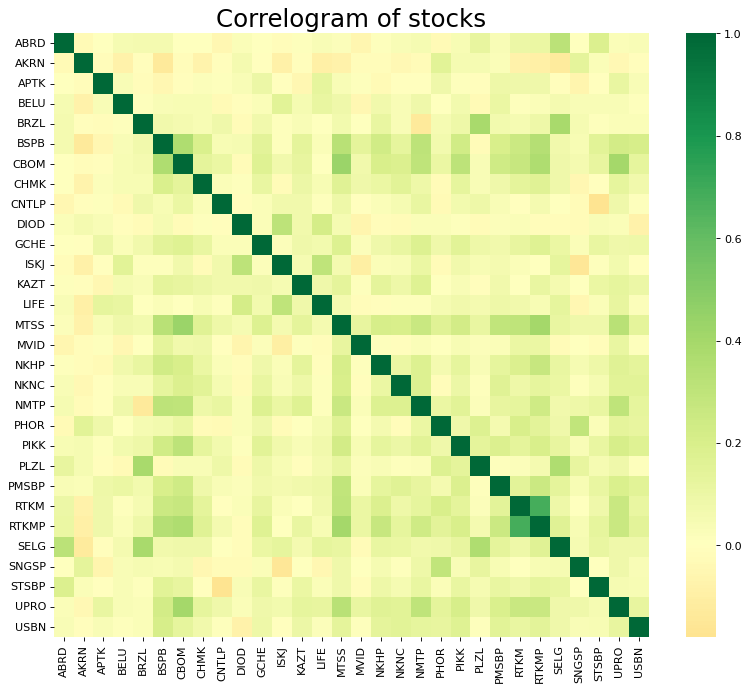

In [65]:
#граифик карты корреляции активовв
def show_corr_map(df):
    plt.figure(figsize=(12,10), dpi= 80)
    sns.heatmap(df.pct_change().corr(), cmap='RdYlGn', center=0, annot=False)
    plt.title('Correlogram of stocks', fontsize=22)
    plt.show()
    
show_corr_map(df)

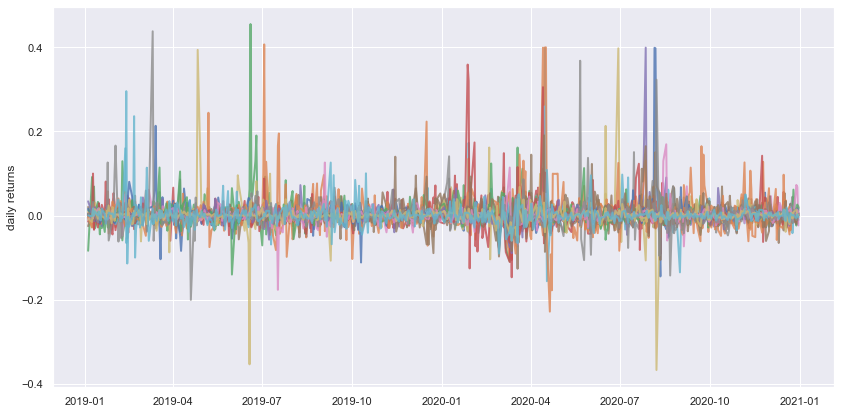

In [175]:
#график дневных доходностей
def show_daily_returns_plt(df):
    returns = df.pct_change()
    returns.index = pd.to_datetime(returns.index)
    plt.figure(figsize=(14, 7))
    for i in returns.columns.values:
        plt.plot(returns.index, returns[i], lw=2, alpha=0.8)
    plt.ylabel('daily returns')
    plt.show()
    
show_daily_returns_plt(df)

Кол-во пробитий уровня VaR состяалвяет 105


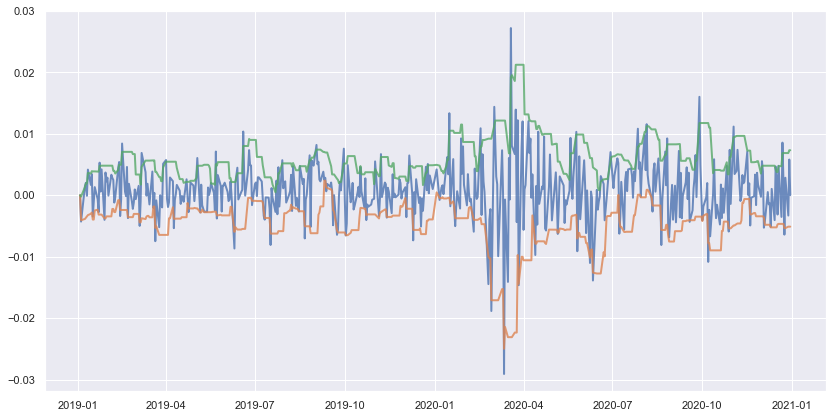

In [357]:
def get_var_quantile(df, weights_dict):
    ind = (df.pct_change() * (np.array(list(weights_dict.values())) / 100)).sum(axis=1).index
    ind = pd.to_datetime(ind)
    dta = (df.pct_change() * (np.array(list(weights_dict.values())) / 100)).sum(axis=1)
    dta.index = pd.to_datetime(dta.index)

    prob = {}

    for i in range(len(dta)):
        if (dta.rolling('14d').quantile(0.05)[i] < dta[i] < dta.rolling('14d').quantile(0.95)[i]) != True:
            prob[dta.index[i]] = dta[i]
            
    print('Кол-во пробитий уровня VaR состяалвяет ' + str(len(prob)))
    plt.figure(figsize=(14, 7))
    plt.plot(ind, dta, lw=2, alpha=0.8)
    plt.plot(dta.index, dta.rolling('14d').quantile(0.05), lw=2, alpha=0.8)
    plt.plot(dta.index, dta.rolling('14d').quantile(0.95), lw=2, alpha=0.8)
    return(prob)

prob = get_var_quantile(df, weights_dict)

## Попробуем посчитать вар с помощью копул

In [225]:
#доходность портфеля
def get_portfolio_returns(df, weights_dict):
    ind = (df.pct_change() * (np.array(list(weights_dict.values())) / 100)).sum(axis=1).index
    ind = pd.to_datetime(ind)
    dta = (df.pct_change() * (np.array(list(weights_dict.values())) / 100)).sum(axis=1)
    dta.index = pd.to_datetime(dta.index)
    return(dta)

In [205]:
#для начала проведем тест shapiro на нормальность распределения доходностей каждого актива

def shapiro_test(df):
    itg = []
    
    for i in list(df.columns):
        itg.append([stats.shapiro(df[i].pct_change()[1:]).statistic, stats.shapiro(df[i].pct_change()[1:]).pvalue])
    
    return(pd.DataFrame(itg, index=list(df.columns), columns=['statistic', 'p-value']))

shapiro_test(df).head()

,statistic,p-value
ABRD,0.311960,1.807423e-39
AKRN,0.905483,4.372172e-17
APTK,0.509153,5.726829e-35
BELU,0.906414,5.343601e-17
BRZL,0.447796,1.661404e-36


In [228]:
from copulas.univariate import Univariate

def get_copulas_for_stocks_and_portf(df, weights_dict):
    univariate = Univariate()
    itg = {}
    for i in list(df.columns):
        univariate.fit(df.pct_change()[i][1:])
        cop = univariate.to_dict()['type']
        itg[i] = cop

    univariate.fit(get_portfolio_returns(df, weights_dict))
    itg['Portfolio'] = univariate.to_dict()['type']
    return(itg)

In [227]:
itg

{'ABRD': 'copulas.univariate.student_t.StudentTUnivariate',
 'AKRN': 'copulas.univariate.student_t.StudentTUnivariate',
 'APTK': 'copulas.univariate.student_t.StudentTUnivariate',
 'BELU': 'copulas.univariate.gaussian_kde.GaussianKDE',
 'BRZL': 'copulas.univariate.student_t.StudentTUnivariate',
 'BSPB': 'copulas.univariate.student_t.StudentTUnivariate',
 'CBOM': 'copulas.univariate.student_t.StudentTUnivariate',
 'CHMK': 'copulas.univariate.student_t.StudentTUnivariate',
 'CNTLP': 'copulas.univariate.student_t.StudentTUnivariate',
 'DIOD': 'copulas.univariate.student_t.StudentTUnivariate',
 'GCHE': 'copulas.univariate.student_t.StudentTUnivariate',
 'ISKJ': 'copulas.univariate.student_t.StudentTUnivariate',
 'KAZT': 'copulas.univariate.student_t.StudentTUnivariate',
 'LIFE': 'copulas.univariate.student_t.StudentTUnivariate',
 'MTSS': 'copulas.univariate.student_t.StudentTUnivariate',
 'MVID': 'copulas.univariate.student_t.StudentTUnivariate',
 'NKHP': 'copulas.univariate.student_t.Stud

In [244]:
get_portfolio_returns(df, weights_dict).reset_index(drop=True)

0      0.000000
1     -0.004281
2      0.001497
3      0.002039
4     -0.000086
         ...   
497   -0.006408
498    0.002852
499   -0.003300
500    0.005814
501    0.000010
Length: 502, dtype: float64

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

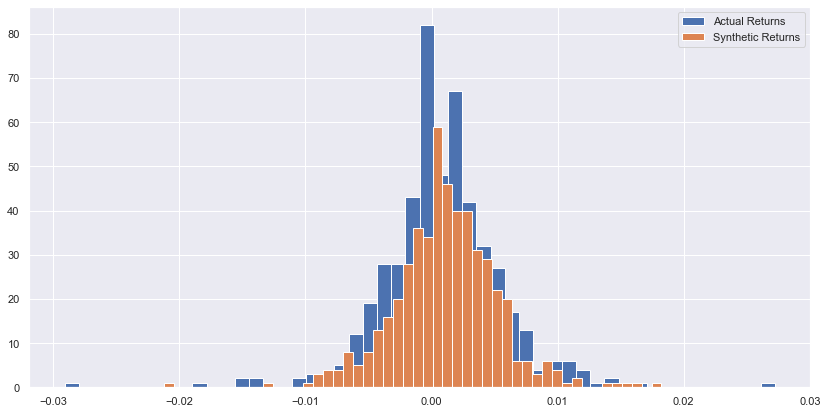

In [308]:
#попробуем сгенерировать данные для распределения доходностей портфеля

from copulas.univariate import Univariate
from copulas.datasets import sample_univariates
from copulas.visualization import compare_1d

def get_synthetic_port_returns(df, weights_dict, grf=True):
    univariate = Univariate()
    data = get_portfolio_returns(df, weights_dict).reset_index(drop=True)
    univariate.fit(data)
    parameters = univariate.to_dict()
    synth_data = univariate.sample(len(get_portfolio_returns(df, weights_dict)))
    
    if grf==True:
        plt.figure(figsize=(14, 7))
        data.hist(bins=50, label = 'Actual Returns')
        pd.Series(synth_data).hist(bins=50, label = 'Synthetic Returns')
        plt.legend()
    return(synth_data)

cop_portf_returns = get_synthetic_port_returns(df, weights_dict)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

Кол-во пробитий уровня VaR состяалвяет 107


107

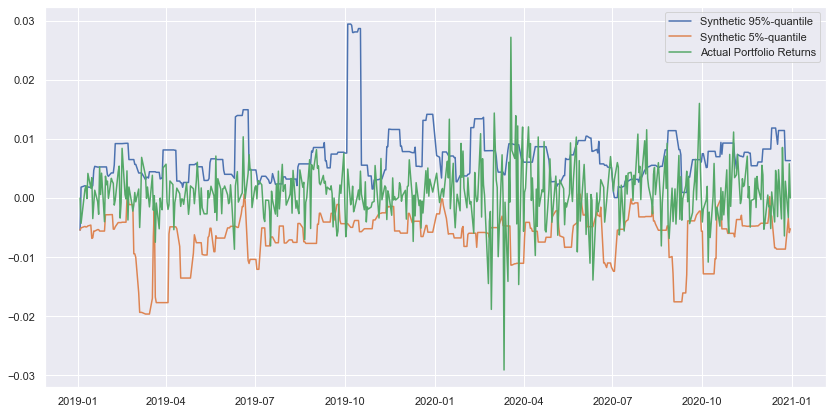

In [379]:
get_gortf_var_prob(df, weights_dict, grph=True)

In [362]:
def get_gortf_var_prob(df, weights_dict, grph=True):
    cop_portf_returns = get_synthetic_port_returns(df, weights_dict, False)

    ind = (df.pct_change() * (np.array(list(weights_dict.values())) / 100)).sum(axis=1).index
    ind = pd.to_datetime(ind)
    dta = (df.pct_change() * (np.array(list(weights_dict.values())) / 100)).sum(axis=1)
    dta.index = pd.to_datetime(dta.index)
    
    xx = pd.DataFrame(cop_portf_returns, index=ind)
    xx.index = pd.to_datetime(xx.index)
    xx = xx[0]
    five = xx.rolling('14d').quantile(0.95)
    nfive = xx.rolling('14d').quantile(0.05)

    itg = {}
    for i in range(len(dta)):
        if (nfive[i] < dta[i] < five[i]) != True:
            itg[dta.index[i]] = dta[i]

    if grph == True:
        print('Кол-во пробитий уровня VaR состяалвяет ' + str(len(itg)))

        plt.figure(figsize=(14, 7))
        plt.plot(five, label='Synthetic 95%-quantile')
        plt.plot(nfive, label='Synthetic 5%-quantile')
        plt.plot(dta, label='Actual Portfolio Returns')
        plt.legend()
    return(len(itg))

portfolio_prob_cop = []
for i in range(1000):
    portfolio_prob_cop.append(get_gortf_var_prob(df, weights_dict, grph=False))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_conti

0    122.935
dtype: float64


<Figure size 1008x504 with 0 Axes>

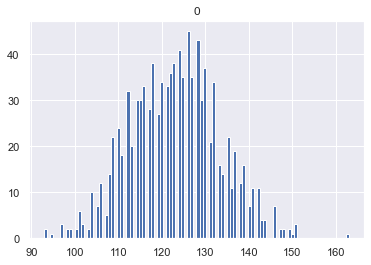

<Figure size 1008x504 with 0 Axes>

In [377]:
print(pd.DataFrame(portfolio_prob_cop).mean())
pd.DataFrame(portfolio_prob_cop).hist(bins=100)
plt.figure(figsize=(14, 7))

In [411]:
#from copulas.multivariate import GaussianMultivariate

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in d

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: invalid value encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5341: RuntimeWarning: divide b

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: invalid value encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5341: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/multivariate/gaussian.py:119: UserWarning: Unable to fit to a <class 'copulas.univariate.base.Univariate'> distribution for column CHMK. Using a Gaussian distribution instead.
  warnings.warn(warning_message)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5341: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrast

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in d

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: invalid value encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5341: RuntimeWarning: divide b

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: invalid value encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5341: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5341: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrast

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in d

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: invalid value encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5341: RuntimeWarning: divide b

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: invalid value encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5341: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in d

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: invalid value encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5341: RuntimeWarning: divide b

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: invalid value encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5341: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in d

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: invalid value encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5341: RuntimeWarning: divide b

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: invalid value encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5341: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in d

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: invalid value encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5341: RuntimeWarning: divide b

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: invalid value encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5341: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in d

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: invalid value encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5341: RuntimeWarning: divide b

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: invalid value encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5341: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in d

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: invalid value encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5341: RuntimeWarning: divide b

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: invalid value encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5341: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in d

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: invalid value encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5341: RuntimeWarning: divide b

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: invalid value encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5341: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in d

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: invalid value encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5341: RuntimeWarning: divide b

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: invalid value encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5341: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in d

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: invalid value encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5341: RuntimeWarning: divide b

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: invalid value encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5341: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in d

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: invalid value encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5341: RuntimeWarning: divide b

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: invalid value encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5341: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in d

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: invalid value encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5341: RuntimeWarning: divide b

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: invalid value encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5341: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in d

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: invalid value encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5341: RuntimeWarning: divide b

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: invalid value encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5341: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in d

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: invalid value encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5341: RuntimeWarning: divide b

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: invalid value encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5341: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in d

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: invalid value encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5341: RuntimeWarning: divide b

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: invalid value encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5341: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in d

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: invalid value encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5341: RuntimeWarning: divide b

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: invalid value encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5341: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in d

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: invalid value encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5341: RuntimeWarning: divide b

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: invalid value encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5341: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in d

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: invalid value encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5341: RuntimeWarning: divide b

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: invalid value encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5341: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in d

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: invalid value encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5341: RuntimeWarning: divide b

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: invalid value encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5341: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in d

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: invalid value encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5341: RuntimeWarning: divide b

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: invalid value encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5341: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in d

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: invalid value encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5341: RuntimeWarning: divide b

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: invalid value encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5341: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in d

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: invalid value encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5341: RuntimeWarning: divide b

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: invalid value encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5341: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in d

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: invalid value encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5341: RuntimeWarning: divide b

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: invalid value encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5341: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in d

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: invalid value encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5341: RuntimeWarning: divide b

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: invalid value encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5341: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in d

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: invalid value encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5341: RuntimeWarning: divide b

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: invalid value encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5341: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in d

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: invalid value encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5341: RuntimeWarning: divide b

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: invalid value encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5341: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in d

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: invalid value encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5341: RuntimeWarning: divide b

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: invalid value encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5341: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in d

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: invalid value encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5341: RuntimeWarning: divide b

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: invalid value encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5341: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in d

0    98.2
dtype: float64


<Figure size 1008x504 with 0 Axes>

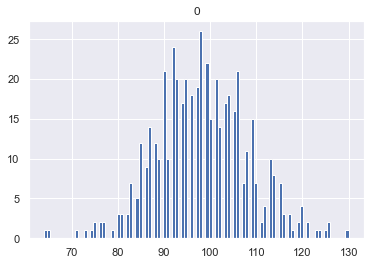

<Figure size 1008x504 with 0 Axes>

In [412]:
def get_multi_cop_var(df, weights_dict, grph=True):
    #sample daily asset returns data from copula
    data = df.pct_change()[1:]
    dist = GaussianMultivariate()
    dist.fit(data)
    sampled = dist.sample(len(df))
    sampled.index = df.index
    
    #get daily portfolio returns from synth data
    sampled = (sampled * (np.array(list(weights_dict.values())) / 100)).sum(axis=1)
    sampled.index = pd.to_datetime(sampled.index)
        
    #get quantiles
    five = sampled.rolling('14d').quantile(0.95)
    nfive = sampled.rolling('14d').quantile(0.05)
    
    #get actual daily portfolio returns 
    ind = (df.pct_change()[1:] * (np.array(list(weights_dict.values())) / 100)).sum(axis=1).index
    ind = pd.to_datetime(ind)
    dta = (df.pct_change()[1:] * (np.array(list(weights_dict.values())) / 100)).sum(axis=1)
    dta.index = pd.to_datetime(dta.index)
    
    
    itg = {}
    for i in range(len(dta)):
        if (nfive[i] < dta[i] < five[i]) != True:
            itg[dta.index[i]] = dta[i]

    if grph == True:
        print('Кол-во пробитий уровня VaR состяалвяет ' + str(len(itg)))

        plt.figure(figsize=(14, 7))
        plt.plot(five, label='Synthetic 95%-quantile')
        plt.plot(nfive, label='Synthetic 5%-quantile')
        plt.plot(dta, label='Actual Portfolio Returns')
        plt.legend()
    return(len(itg))

portfolio_prob_cop = []
for i in range(1000):
    portfolio_prob_cop.append(get_multi_cop_var(df, weights_dict, grph=False))

print(pd.DataFrame(portfolio_prob_cop).mean())
pd.DataFrame(portfolio_prob_cop).hist(bins=100)
plt.figure(figsize=(14, 7))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/copulas/univariate

Кол-во пробитий уровня VaR состяалвяет 94


94

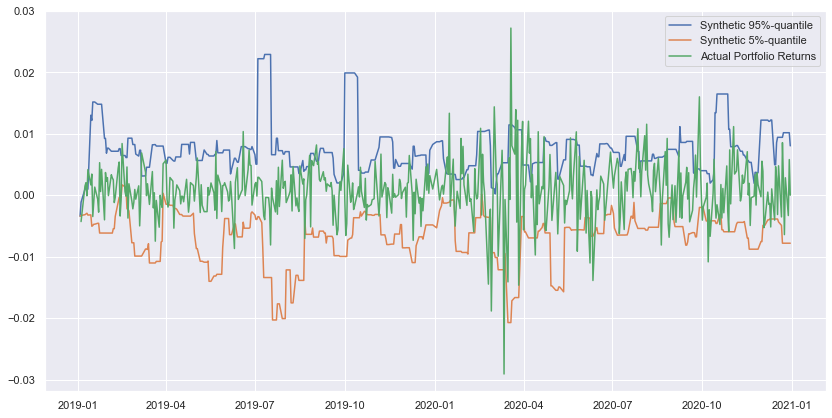

In [413]:
get_multi_cop_var(df, weights_dict, grph=True)

In [389]:
itg

{'ABRD': 'copulas.univariate.student_t.StudentTUnivariate',
 'AKRN': 'copulas.univariate.student_t.StudentTUnivariate',
 'APTK': 'copulas.univariate.student_t.StudentTUnivariate',
 'BELU': 'copulas.univariate.gaussian_kde.GaussianKDE',
 'BRZL': 'copulas.univariate.student_t.StudentTUnivariate',
 'BSPB': 'copulas.univariate.student_t.StudentTUnivariate',
 'CBOM': 'copulas.univariate.student_t.StudentTUnivariate',
 'CHMK': 'copulas.univariate.student_t.StudentTUnivariate',
 'CNTLP': 'copulas.univariate.student_t.StudentTUnivariate',
 'DIOD': 'copulas.univariate.student_t.StudentTUnivariate',
 'GCHE': 'copulas.univariate.student_t.StudentTUnivariate',
 'ISKJ': 'copulas.univariate.student_t.StudentTUnivariate',
 'KAZT': 'copulas.univariate.student_t.StudentTUnivariate',
 'LIFE': 'copulas.univariate.student_t.StudentTUnivariate',
 'MTSS': 'copulas.univariate.student_t.StudentTUnivariate',
 'MVID': 'copulas.univariate.student_t.StudentTUnivariate',
 'NKHP': 'copulas.univariate.student_t.Stud

Кол-во пробитий уровня VaR состяалвяет 125


{Timestamp('2019-01-03 00:00:00'): 0.0,
 Timestamp('2019-01-04 00:00:00'): -0.004281078518050771,
 Timestamp('2019-01-08 00:00:00'): 0.0014971318441866306,
 Timestamp('2019-01-11 00:00:00'): 0.004175775513363004,
 Timestamp('2019-01-14 00:00:00'): 0.001685894401407399,
 Timestamp('2019-01-15 00:00:00'): 0.003452393249633556,
 Timestamp('2019-01-21 00:00:00'): -0.0006303867967500479,
 Timestamp('2019-01-22 00:00:00'): -0.0027493262661095453,
 Timestamp('2019-01-23 00:00:00'): 0.005307311186421224,
 Timestamp('2019-01-29 00:00:00'): 0.0037030074971406697,
 Timestamp('2019-02-07 00:00:00'): -0.0011886956262532923,
 Timestamp('2019-02-14 00:00:00'): -0.0007337072206198412,
 Timestamp('2019-02-20 00:00:00'): 0.004609362154396937,
 Timestamp('2019-02-28 00:00:00'): 0.0009475254998519878,
 Timestamp('2019-03-01 00:00:00'): -0.0006362187419057458,
 Timestamp('2019-03-04 00:00:00'): 0.0015350182017075651,
 Timestamp('2019-03-11 00:00:00'): 0.0037688144868616995,
 Timestamp('2019-03-13 00:00:00'

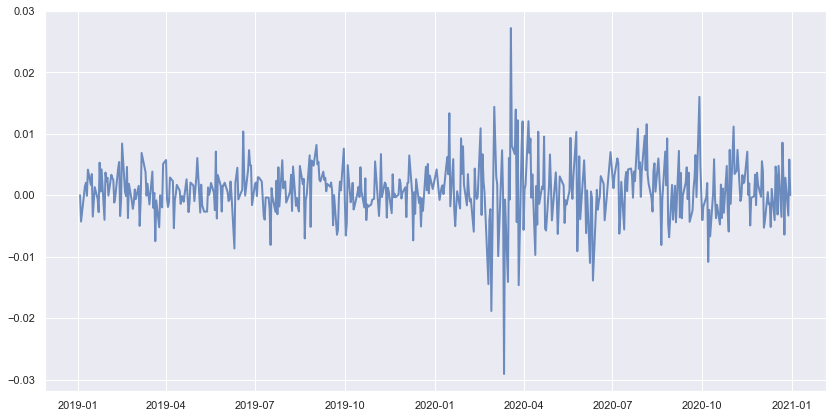

In [297]:
def get_var_quantile_portf_copula(df, weights_dict, cop_portf_returns):
    ind = (df.pct_change() * (np.array(list(weights_dict.values())) / 100)).sum(axis=1).index
    ind = pd.to_datetime(ind)
    dta = (df.pct_change() * (np.array(list(weights_dict.values())) / 100)).sum(axis=1)
    dta.index = pd.to_datetime(dta.index)

    prob = {}

    for i in range(len(dta)):
        if cop_portf_returns[i] > dta.rolling('14d').quantile(0.95)[i] or cop_portf_returns[i] < dta.rolling('14d').quantile(0.05)[i]:
            prob[dta.index[i]] = dta[i]
    
    cop_portf_returns = pd.DataFrame(cop_portf_returns, index=ind)
    cop_portf_returns.index = pd.to_datetime(cop_portf_returns.index)
    
    print('Кол-во пробитий уровня VaR состяалвяет ' + str(len(prob)))
    plt.figure(figsize=(14, 7))
    plt.plot(ind, dta, lw=2, alpha=0.8)
    
    #plt.plot(cop_portf_returns.index, cop_portf_returns.rolling('14d').quantile(0.05), lw=2, alpha=0.8)
    #plt.plot(cop_portf_returns.index, cop_portf_returns.rolling('14d').quantile(0.95), lw=2, alpha=0.8)
    
    
    return(prob)

get_var_quantile_portf_copula(df, weights_dict, cop_portf_returns)